In [28]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import math

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
z_dim = 100
image_size = 28
nc = 1
ngf = 64
ndf = 64
batch_size = 128
epochs = 30
lr = 2e-4
beta1 = 0.5


In [31]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [32]:
import os

dir = "dcgan_out"
os.makedirs(dir,exist_ok=True)

In [33]:
train_data = datasets.MNIST(dir,train=True,download=True,transform=transform)
test_data = datasets.MNIST(dir,train=False,download=True,transform=transform)

In [34]:
train_dataloader = DataLoader(train_data)
test_dataloader = DataLoader(test_data)

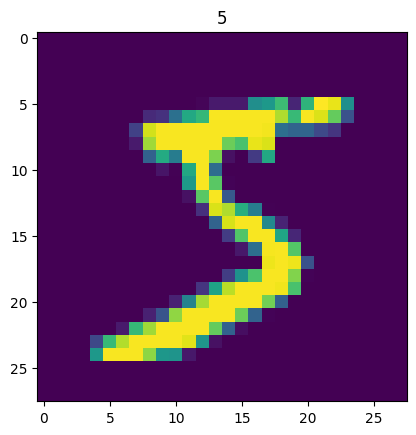

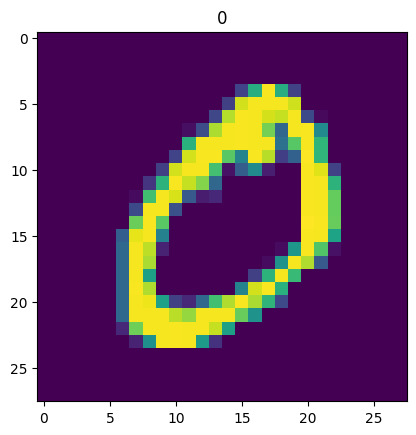

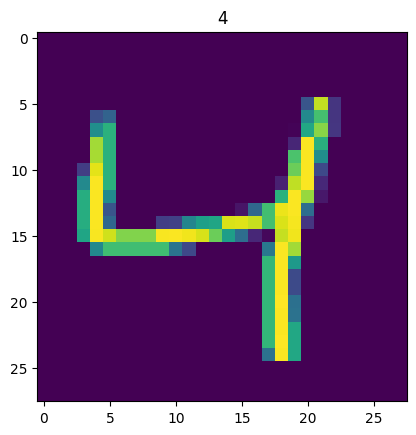

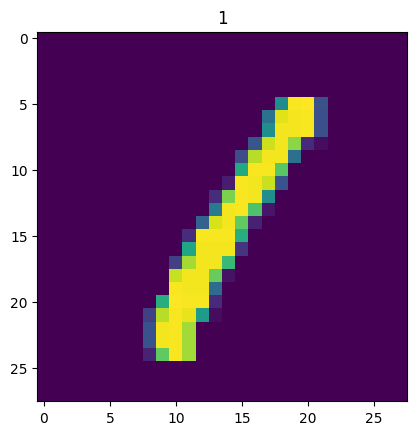

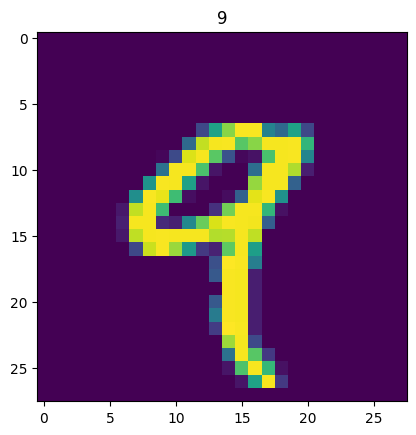

In [35]:
train_itr = iter(train_dataloader)
def showImages(itr,count):
  for _ in range(count):
    image,label = next(train_itr)
    plt.imshow(image[0][0])
    plt.title(label.item())
    plt.show()

showImages(train_itr,5)

In [36]:
loader = DataLoader(train_data,batch_size=batch_size,num_workers=2,shuffle=True,pin_memory=True)

In [37]:
loader

In [38]:
len(loader)

469

In [39]:
class Genrator(nn.Module):
  def __init__(self,z_dim,nc,ngf):
    super().__init__()
    self.genrator = nn.Sequential(
        nn.ConvTranspose2d(z_dim,ngf*4,7,1,0,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf*4,ngf*4,7,1,0,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf*4,ngf*4,7,1,0,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf*4,ngf*4,7,1,0,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        nn.Conv2d(ngf*4,nc,3,1,1,bias=False),
        nn.Tanh()
    )

  def forward(self,z):
    z = z.view(z.size(0), z.size(1), 1, 1)
    return self.genrator(z)

In [40]:
class Discriminator(nn.Module):
  def __init__(self,nc,ndf):
    super().__init__()
    self.discriminator = nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf*2, 1, 6, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self,x):
    return self.discriminator(x)

In [41]:
G = Genrator(z_dim,nc,ngf)
D = Discriminator(nc,ndf)

In [42]:
criterion = nn.BCELoss()
opd = torch.optim.Adam(D.parameters(),lr=lr,betas=(beta1,0.999))
opg = torch.optim.Adam(G.parameters(),lr=lr,betas=(beta1,0.999))

In [43]:
fixed_noise = torch.randn(64,z_dim,device=device)
G=G.to(device)
D = D.to(device)

In [46]:
real_label = 1.0
fake_label = 0.0

for epoch in range(epochs):
    for i, (image, _) in enumerate(loader):
        image = image.to(device)
        bsize = image.size(0)

        ### ---------------------------------------
        ### Train Discriminator
        ### ---------------------------------------
        D.zero_grad()

        # 1. REAL
        out_real = D(image)                   # shape [B,1,2,2]
        labels_real = torch.full_like(out_real, real_label, dtype=torch.float)
        loss_real = criterion(out_real, labels_real)
        loss_real.backward()

        # 2. FAKE
        noise = torch.randn(bsize, z_dim, device=device)
        fake = G(noise)
        out_fake = D(fake.detach())           # shape [B,1,2,2]
        labels_fake = torch.full_like(out_fake, fake_label, dtype=torch.float)
        loss_fake = criterion(out_fake, labels_fake)
        loss_fake.backward()

        lossD = loss_real + loss_fake
        opd.step()

        ### ---------------------------------------
        ### Train Generator
        ### ---------------------------------------
        G.zero_grad()

        out_forG = D(fake)                    # shape [B,1,2,2]
        labels_forG = torch.full_like(out_forG, real_label, dtype=torch.float)
        lossG = criterion(out_forG, labels_forG)
        lossG.backward()
        opg.step()

        if i % 200 == 0:
            print(f"Epoch {epoch}/{epochs}  Batch {i}/{len(loader)}  LossD: {lossD.item():.4f}  LossG: {lossG.item():.4f}")

    # Save samples
    with torch.no_grad():
        sample = G(fixed_noise).cpu()
        grid = make_grid(sample, nrow=8, normalize=True, value_range=(-1, 1))
        save_image(grid, os.path.join(dir, f"epoch_{epoch:03d}.png"))

torch.save(G.state_dict(), os.path.join(dir, "G.pth"))
torch.save(D.state_dict(), os.path.join(dir, "D.pth"))
print("Training complete.")


Epoch 0/30  Batch 0/469  LossD: 1.3626  LossG: 1.3725
Epoch 0/30  Batch 200/469  LossD: 0.1468  LossG: 3.3927
Epoch 0/30  Batch 400/469  LossD: 0.0490  LossG: 3.8836
Epoch 1/30  Batch 0/469  LossD: 0.0347  LossG: 4.2292
Epoch 1/30  Batch 200/469  LossD: 0.0169  LossG: 4.9359
Epoch 1/30  Batch 400/469  LossD: 0.0084  LossG: 5.5901
Epoch 2/30  Batch 0/469  LossD: 0.0115  LossG: 5.3493
Epoch 2/30  Batch 200/469  LossD: 0.0042  LossG: 6.3910
Epoch 2/30  Batch 400/469  LossD: 0.0070  LossG: 5.6511
Epoch 3/30  Batch 0/469  LossD: 0.0058  LossG: 6.1570
Epoch 3/30  Batch 200/469  LossD: 0.0057  LossG: 5.9994
Epoch 3/30  Batch 400/469  LossD: 0.0033  LossG: 6.6357
Epoch 4/30  Batch 0/469  LossD: 0.0029  LossG: 6.3610
Epoch 4/30  Batch 200/469  LossD: 0.0023  LossG: 6.6005
Epoch 4/30  Batch 400/469  LossD: 0.0017  LossG: 7.9603
Epoch 5/30  Batch 0/469  LossD: 0.0013  LossG: 7.3849
Epoch 5/30  Batch 200/469  LossD: 0.0019  LossG: 6.8305
Epoch 5/30  Batch 400/469  LossD: 0.0015  LossG: 7.1403
Epoc

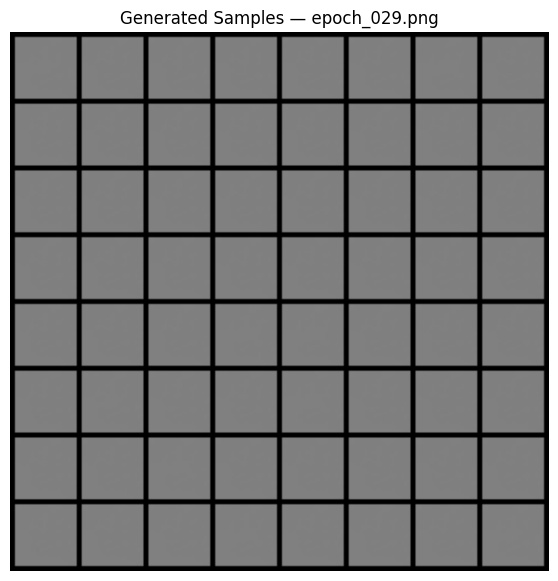

In [49]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_generated_images(img_dir, epoch=None):

    files = [f for f in os.listdir(img_dir) if f.endswith(".png")]
    if not files:
        print("No images found in folder.")
        return

    if epoch is not None:
        fname = f"epoch_{epoch:03d}.png"
        if fname not in files:
            print(f"{fname} not found in directory.")
            return
    else:
        fname = sorted(files)[-1]

    # Load image
    path = os.path.join(img_dir, fname)
    img = Image.open(path)

    # Plot
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Generated Samples — {fname}")
    plt.show()

show_generated_images(dir)
